## Improving Accuracy of Simulated Flows in Steeply Dipping Layers Using Vertically Staggered Grids with the XT3D Multi-Point Flux Approximation in MODFLOW 6

In [1]:
%run ./routines.ipynb
%run ./figures.ipynb
ws = './disu_model'

In [2]:
# Lx is the full width of the model. The grid spacing in the x direction is
# delr = Lx / ncol, and so the horizontal distance between the left and right
# boundary conditions is Lx - delr. The cells in the channel are square, i.e.,
# delz_chan = delr. The cross-sectional model has unit thickness "into the page,"
# i.e., nrow = 1 and delc = 1.

# The full thickness of the channel measured vertically is nlay_chan * delz_chan.
# Theta is the angle (deg) at which the channel slopes, and so the width of the
# true" channel measured perpendicularly to the slope, i.e., the width available 
# for flow along the slope of the channel, is nlay_chan * delz_chan * cos(theta).
# The increase in elevation (vertical offset) as one moves a column to the right
# within the channel is delr * tan(theta).

# adjustable grid parameters
nlay_chan, ncol = 3, 11         # number of layers in channel, and number of columns in model
Lx = 11.0                       # full horizontal width of model
theta = 30.                     # angle of inclination of channel
domain = True                    # option to include "domain" (True) or not (False)
k_dom = 1.e-6                   # domain conductivity

# grid parameters intended to remain fixed
nrow = 1                        # model is one row deep "into the page"
delc = 1.                       # model has unit width "into the page"

# computed grid parameters
if domain:
    nlay_dom_upper = nlay_chan                      # number of layers in upper domain
else:
    nlay_dom_upper = 0
nlay_dom_lower = nlay_dom_upper                     # number of layers in lower domain
nlay = nlay_chan + nlay_dom_upper + nlay_dom_lower  # total number of layers
delr = float(Lx / ncol)                             # horizontal cell size
delz_chan = delr                                    # vertical cell size in channel
zoffset = delr * math.tan(theta * math.pi / 180.)   # vertical offset between cells in channel
zthick = nlay_chan * delz_chan                      # vertical thickness of channel
zspan = (ncol - 1) * zoffset + zthick               # total vertical span of channel
zthick_dom_ll = zthick                              # vertical thickness of lower domain at left boundary
zthick_dom_ur = zthick                              # vertical thickness of upper domain at right boundary

# set tops, bottoms, and conductivities; midpoints of cell tops/bottoms fall along
# the "true" top/bottom channel boundaries
botm = np.empty((nlay, nrow, ncol))
cond = np.ones((nlay, nrow, ncol))                  # unit conductivity in channel, set as default here
top_chan = zthick + 0.5 * zoffset \
    + np.linspace(0., (ncol - 1) * zoffset, ncol)
top_chan = top_chan.reshape((nrow, ncol))           # top of channel (without domain)
if domain:
    # upper domain
    Lz = zthick_dom_ll + zspan + zthick_dom_ur      # total height of model
    top_chan += zthick_dom_ll                       # add left-boundary thickness of lower domain to top of channel
    top = np.ones((nrow, ncol)) * Lz                # top of model
    dz = (top - top_chan) / nlay_dom_upper          # vertical cell size varies by column in domain
    botm[0] = top - dz                              # bottom of first layer is calculated using top
    cond[0] = k_dom
    for klay in range(1, nlay_dom_upper):
        botm[klay] = botm[klay - 1] - dz
        cond[klay] = k_dom
    # prepare to continue with channel discretization
    klaycontinue = nlay_dom_upper
else:
    # initialize channel discretization
    Lz = zspan                                     # total height of model
    top = top_chan                                 # top of model is top of channel
    botm[0] = top - delz_chan                      # bottom of first layer is calculated using top
    # prepare to continue channel discretization
    klaycontinue = 1
# channel
for klay in range(klaycontinue, nlay_dom_upper + nlay_chan):
    botm[klay] = botm[klay - 1] - delz_chan
if domain:
    # lower domain
    dz = (top_chan - zthick) / nlay_dom_lower     # vertical cell size varies by column in domain
    for klay in range(nlay_dom_upper + nlay_chan, nlay):
        botm[klay] = botm[klay - 1] - dz
        cond[klay] = k_dom

delr = delr * np.ones(ncol, dtype=float)
delc = delc * np.ones(nrow, dtype=float)
mgs = flopy.discretization.StructuredGrid(delr=delr, delc=delc, top=top, botm=botm)


In [3]:
# scenario parameters
# scenario names -- keys of parameters dictionary are scenario names
#                   built automatically from scenario options
# crossflow -- analytical flow is across the channel, i.e., crossflow (True)
#              or along the channel, i.e., axial flow (False)
# staggered -- vertically staggered grid, i.e., cross-connections (True)
#              or not, i.e., vertically offset (False)
# xt3d -- xt3d on (True) or off, i.e., standard formulation (False)

# scenario options
options = [
    {
        "optionname": "crossflow",
        "optionstrings": {
            False: "-af",
            True: "-cf",
        },   
    },
    {
        "optionname": "staggered",
        "optionstrings": {
            False: "-vo",
            True: "-vs",
        },
    },
    {
        "optionname": "xt3d",
        "optionstrings": {
            False: "-s",
            True: "-x",
        },
    },
]

# build parameters dictionary
parameters = build_parameters(options)

In [4]:
# run scenarios
models_all, head_all, spdis_all, q_all = [], [], [], []
for i in range(len(parameters)):
    qmagmid, qangmid, gwf, head, spdis = simulation(i)
    models_all.append(gwf), head_all.append(head), spdis_all.append(spdis)
    q_all.append((qmagmid, qangmid))

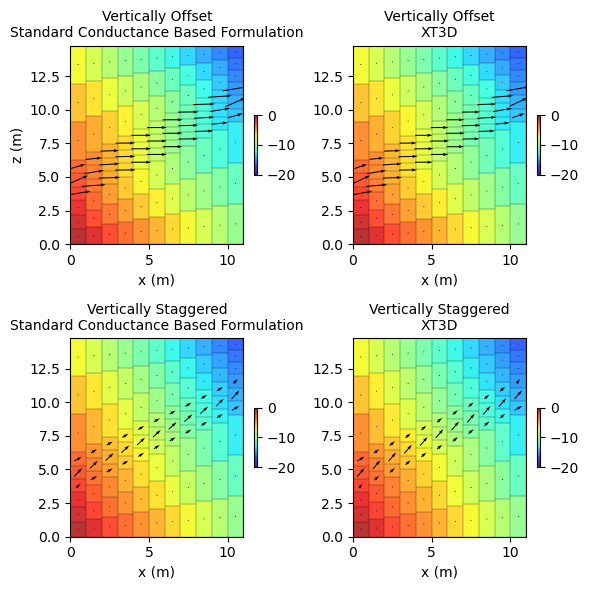

In [5]:
fig2(vmin = -20, vmax = 0)

In [6]:
table1()

Vertically Offset
Standard Conductance Based Formulation
qmagmid =  1.1547291156826645
qangmid =  0.4034294779748257 

Vertically Offset
XT3D
qmagmid =  1.0992720481914613
qangmid =  0.36927083377992975 

Vertically Staggered
Standard Conductance Based Formulation
qmagmid =  1.028434777353554
qangmid =  24.135952871871353 

Vertically Staggered
XT3D
qmagmid =  1.0073594916146336
qangmid =  30.138051012115234 



### Investigating adding model layers within hydrogeologic layers 

In [7]:
resolution_scenarios = np.arange(1,10,1)
nr = len(resolution_scenarios)
vo_results, vs_results = [], []

for n in range(nr):

    nlay_chan = resolution_scenarios[n] # number of layers in channel, and number of columns in model
    Lx = 11.0                       # full horizontal width of model
    theta = 30.                     # angle of inclination of channel
    domain = True                   # option to include "domain" (True) or not (False)
    k_dom = 1.e-6                   # domain conductivity
    nrow = 1                        # model is one row deep "into the page"
    delc = 1.                       # model has unit width "into the page"

    # computed grid parameters
    if domain:
        nlay_dom_upper = nlay_chan                      # number of layers in upper domain
    else:
        nlay_dom_upper = 0
    nlay_dom_lower = nlay_dom_upper                     # number of layers in lower domain
    nlay = nlay_chan + nlay_dom_upper + nlay_dom_lower  # total number of layers
    delr = float(Lx / ncol)                             # horizontal cell size
    delz_chan = delr                                    # vertical cell size in channel
    zoffset = delr * math.tan(theta * math.pi / 180.)   # vertical offset between cells in channel
    zthick = nlay_chan * delz_chan                      # vertical thickness of channel
    zspan = (ncol - 1) * zoffset + zthick               # total vertical span of channel
    zthick_dom_ll = zthick                              # vertical thickness of lower domain at left boundary
    zthick_dom_ur = zthick                              # vertical thickness of upper domain at right boundary

    ncol = int(Lx/delz_chan)
    
    # set tops, bottoms, and conductivities; midpoints of cell tops/bottoms fall along
    # the "true" top/bottom channel boundaries
    botm = np.empty((nlay, nrow, ncol))
    cond = np.ones((nlay, nrow, ncol))                  # unit conductivity in channel, set as default here
    top_chan = zthick + 0.5 * zoffset \
        + np.linspace(0., (ncol - 1) * zoffset, ncol)
    top_chan = top_chan.reshape((nrow, ncol))           # top of channel (without domain)
    if domain:
        # upper domain
        Lz = zthick_dom_ll + zspan + zthick_dom_ur      # total height of model
        top_chan += zthick_dom_ll                       # add left-boundary thickness of lower domain to top of channel
        top = np.ones((nrow, ncol)) * Lz                # top of model
        dz = (top - top_chan) / nlay_dom_upper          # vertical cell size varies by column in domain
        botm[0] = top - dz                              # bottom of first layer is calculated using top
        cond[0] = k_dom
        for klay in range(1, nlay_dom_upper):
            botm[klay] = botm[klay - 1] - dz
            cond[klay] = k_dom
        # prepare to continue with channel discretization
        klaycontinue = nlay_dom_upper
    else:
        # initialize channel discretization
        Lz = zspan                                     # total height of model
        top = top_chan                                 # top of model is top of channel
        botm[0] = top - delz_chan                      # bottom of first layer is calculated using top
        # prepare to continue channel discretization
        klaycontinue = 1
    # channel
    for klay in range(klaycontinue, nlay_dom_upper + nlay_chan):
        botm[klay] = botm[klay - 1] - delz_chan
    if domain:
        # lower domain
        dz = (top_chan - zthick) / nlay_dom_lower     # vertical cell size varies by column in domain
        for klay in range(nlay_dom_upper + nlay_chan, nlay):
            botm[klay] = botm[klay - 1] - dz
            cond[klay] = k_dom

    # plot dis grid
    delr = delr * np.ones(ncol, dtype=float)
    delc = delc * np.ones(nrow, dtype=float)
    mgs = flopy.discretization.StructuredGrid(delr=delr, delc=delc,
                                              top=top, botm=botm)
    
    # run scenarios
    for i in range(len(parameters)):
        qmagmid, qangmid, gwf, head, spdis = simulation(i)
        if i == 1: vo_results.append((nlay_chan, qmagmid, qangmid)) # i=1 VO(XT3D)
        if i == 3: vs_results.append((nlay_chan, qmagmid, qangmid)) # i=3 VS(XT3D)

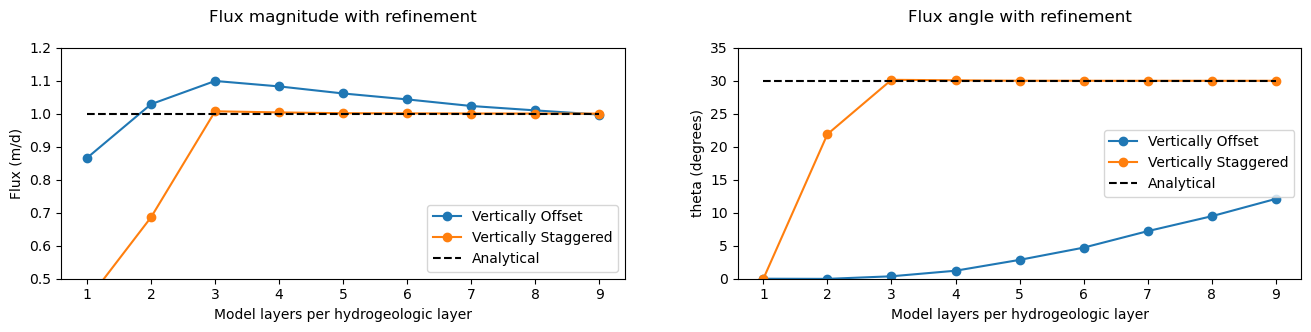

In [8]:
fig3()

### Investigating K contrast bewteen hydrogeologic layer and domain

In [12]:
#scenario = 3 # 0: VO, 1: VO-XT3D, 2: VS, 3: VS-XT3D

dip = np.arange(0,80,1) # For nice contours use (0,80,1)
log = np.arange(0, 4, 0.2) # For nice contours use (0,4,0.2)
Kcontrast = [10**i for i in log]
qmag_results = np.zeros((4, len(Kcontrast), len(dip)))
qtheta_results = np.zeros((4, len(Kcontrast), len(dip)))
dip_array = np.zeros((4, len(Kcontrast), len(dip)))
Kcontrast_array = np.zeros((4, len(Kcontrast), len(dip)))

qmag_results.shape

(4, 20, 80)

In [13]:
for s in range(4): # options 0, 1, 2, 3
    for kc in range(len(Kcontrast)):
        for d in range(len(dip)):

            nlay_chan = 3                   # number of layers in channel, and number of columns in model
            Lx = 11.0                       # full horizontal width of model
            theta = dip[d]                  # angle of inclination of channel
            k_dom = 1/Kcontrast[kc]         # domain conductivity
            #theta = math.atan(0.5) * 180. / math.pi
            domain = True                   # option to include "domain" (True) or not (False)

            nrow = 1                        # model is one row deep "into the page"
            delc = 1.                       # model has unit width "into the page"

            # computed grid parameters
            if domain:
                nlay_dom_upper = nlay_chan                      # number of layers in upper domain
            else:
                nlay_dom_upper = 0
            nlay_dom_lower = nlay_dom_upper                     # number of layers in lower domain
            nlay = nlay_chan + nlay_dom_upper + nlay_dom_lower  # total number of layers
            delr = float(Lx / ncol)                             # horizontal cell size
            delz_chan = delr                                    # vertical cell size in channel
            zoffset = delr * math.tan(theta * math.pi / 180.)   # vertical offset between cells in channel
            zthick = nlay_chan * delz_chan                      # vertical thickness of channel
            zspan = (ncol - 1) * zoffset + zthick               # total vertical span of channel
            zthick_dom_ll = zthick                              # vertical thickness of lower domain at left boundary
            zthick_dom_ur = zthick                              # vertical thickness of upper domain at right boundary

            ncol = int(Lx/delz_chan)

            # set tops, bottoms, and conductivities; midpoints of cell tops/bottoms fall along
            # the "true" top/bottom channel boundaries
            botm = np.empty((nlay, nrow, ncol))
            cond = np.ones((nlay, nrow, ncol))                  # unit conductivity in channel, set as default here
            top_chan = zthick + 0.5 * zoffset \
                + np.linspace(0., (ncol - 1) * zoffset, ncol)
            top_chan = top_chan.reshape((nrow, ncol))           # top of channel (without domain)
            if domain:
                # upper domain
                Lz = zthick_dom_ll + zspan + zthick_dom_ur      # total height of model
                top_chan += zthick_dom_ll                       # add left-boundary thickness of lower domain to top of channel
                top = np.ones((nrow, ncol)) * Lz                # top of model
                dz = (top - top_chan) / nlay_dom_upper          # vertical cell size varies by column in domain
                botm[0] = top - dz                              # bottom of first layer is calculated using top
                cond[0] = k_dom
                for klay in range(1, nlay_dom_upper):
                    botm[klay] = botm[klay - 1] - dz
                    cond[klay] = k_dom
                # prepare to continue with channel discretization
                klaycontinue = nlay_dom_upper
            else:
                # initialize channel discretization
                Lz = zspan                                     # total height of model
                top = top_chan                                 # top of model is top of channel
                botm[0] = top - delz_chan                      # bottom of first layer is calculated using top
                # prepare to continue channel discretization
                klaycontinue = 1
            # channel
            for klay in range(klaycontinue, nlay_dom_upper + nlay_chan):
                botm[klay] = botm[klay - 1] - delz_chan
            if domain:
                # lower domain
                dz = (top_chan - zthick) / nlay_dom_lower     # vertical cell size varies by column in domain
                for klay in range(nlay_dom_upper + nlay_chan, nlay):
                    botm[klay] = botm[klay - 1] - dz
                    cond[klay] = k_dom

            # plot dis grid
            delr = delr * np.ones(ncol, dtype=float)
            delc = delc * np.ones(nrow, dtype=float)
            mgs = flopy.discretization.StructuredGrid(delr=delr, delc=delc,
                                                      top=top, botm=botm)

            #print('\nk_contrast = %i, dip = %i, scenario = %i' %(Kcontrast[kc], dip[d], s))
            qmagmid, qangmid, gwf, head, spdis = simulation(s)
            qmag_results[s][kc][d] = abs(qmagmid - 1) # error
            qtheta_results[s][kc][d] = abs((qangmid - theta)/theta) # error  
            Kcontrast_array[s][kc][d] = Kcontrast[kc]
            dip_array[s][kc][d] = dip[d]

C:\Users\19904604\AppData\Local\Temp\ipykernel_15236\977351939.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(121)
C:\Users\19904604\AppData\Local\Temp\ipykernel_15236\977351939.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(122)


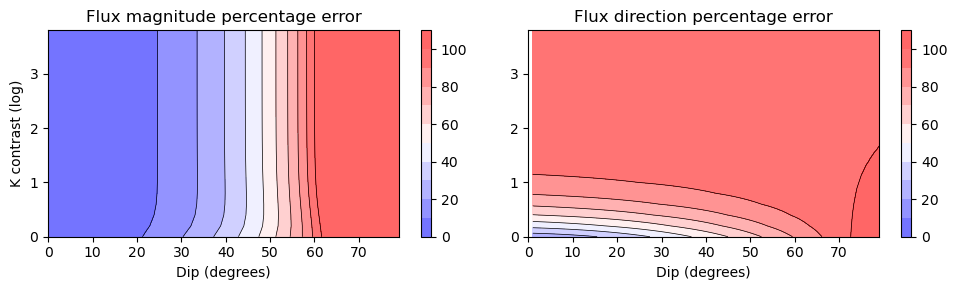

C:\Users\19904604\AppData\Local\Temp\ipykernel_15236\977351939.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(121)
C:\Users\19904604\AppData\Local\Temp\ipykernel_15236\977351939.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(122)


<Figure size 640x480 with 0 Axes>

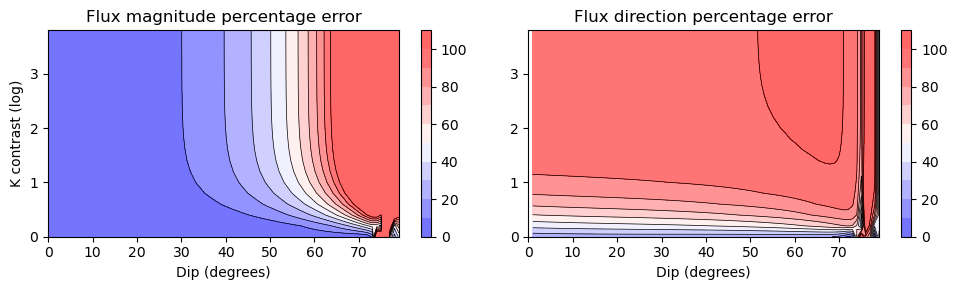

C:\Users\19904604\AppData\Local\Temp\ipykernel_15236\977351939.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(121)
C:\Users\19904604\AppData\Local\Temp\ipykernel_15236\977351939.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(122)


<Figure size 640x480 with 0 Axes>

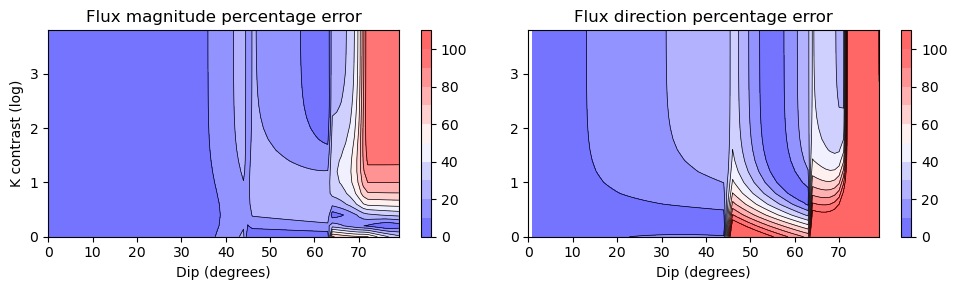

C:\Users\19904604\AppData\Local\Temp\ipykernel_15236\977351939.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(121)
C:\Users\19904604\AppData\Local\Temp\ipykernel_15236\977351939.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(122)


<Figure size 640x480 with 0 Axes>

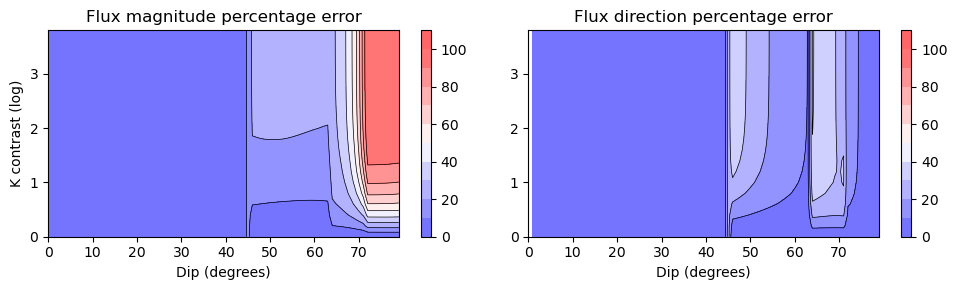

<Figure size 640x480 with 0 Axes>

In [14]:
fig4()